st implementation done without any arc or beam beam effects

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xobjects as xo
import xtrack as xt
import xfields as xf
import xpart as xp
from numpy.random import rand
from xobjects import ContextCpu, ContextCupy, ContextPyopencl
from xfields import TriLinearInterpolatedFieldMap
import time

In [2]:
context = xo.ContextCpu()
#context = ContextCupy(default_block_size=256)
#context = ContextPyopencl()

In [3]:
print(repr(context))

In [11]:
p0c = 6500e9
bunch_intensity = 0.7825E11
physemit_x = (2.946E-6*xp.PROTON_MASS_EV)/p0c 
physemit_y = (2.946E-6*xp.PROTON_MASS_EV)/p0c 
beta_x = 19.17
beta_y = 19.17
sigma_z = 0.08
sigma_delta = 1E-4
beta_s = sigma_z/sigma_delta
Qx = 64.31
Qy = 59.32
Qs = 2.1E-3
frev = 11245.5 
nTurn = 10
n_macroparticles = int(1e7)
sigma = np.sqrt(physemit_x*beta_x)
nxs = [1500, 2000]
lumis = []

In [12]:
def Lumi_analytical(Nb, N1, N2, frev, Delta_i, sig_i, sig_x, sig_y):
    W = np.exp(-Delta_i**2/(4*sig_i**2))
    return ((Nb * N1 * N2 * frev * W)/(4 * np.pi * sig_x * sig_y))

In [6]:
def compute_lumi_integral(lumigrid_mybeam, lumigrid_other_beam, beam_intensity, other_beam_intensity, frev):
        sum1 = np.sum(lumigrid_mybeam.rho[:,:,1])
        sum2 = np.sum(lumigrid_other_beam.rho[:,:,1])
        dx = lumigrid_mybeam.dx
        dy = lumigrid_mybeam.dy
        nx = lumigrid_mybeam.nx
        ny = lumigrid_mybeam.ny
        scale1 = 1.0/(sum1*dx*dy)
        scale2 = 1.0/(sum2*dx*dy)
        h1_scaled = lumigrid_mybeam.rho[:,:,1]*scale1
        h2_scaled = lumigrid_other_beam.rho[:,:,1]*scale2
        h_multiplied = h1_scaled*h2_scaled
        integral = 0.25*dx*dy*(h_multiplied[0,0]+h_multiplied[nx-1,0]+h_multiplied[0,ny-1]+h_multiplied[nx-1,ny-1])
        secondPart = 0
        thirdPart = 0
        fourthPart = 0
        for i in range(nx-1):
                for j in range(ny-1):
                        secondPart += h_multiplied[i+1,j+1]
        for i in range(nx-1):
                thirdPart += h_multiplied[i+1,0]+h_multiplied[i+1,ny-1]
        for i in range(ny-1): 
                fourthPart += h_multiplied[0,i+1]+h_multiplied[nx-1,i+1]
                
        integralf= integral + 0.25*dx*dy*(4*secondPart+2*thirdPart+2*fourthPart)
        numerical_luminosity = beam_intensity*other_beam_intensity*frev*integralf
        return numerical_luminosity

In [7]:
for nx in nxs:
        
        particles_b1 = xp.Particles(_context=context,
                p0c=p0c,
                x=np.sqrt(physemit_x*beta_x)*(np.random.randn(n_macroparticles)),
                px=np.sqrt(physemit_x/beta_x)*np.random.randn(n_macroparticles),
                y=np.sqrt(physemit_y*beta_y)*(np.random.randn(n_macroparticles)),
                py=np.sqrt(physemit_y/beta_y)*np.random.randn(n_macroparticles),
                zeta=sigma_z*np.random.randn(n_macroparticles),
                delta=sigma_delta*np.random.randn(n_macroparticles),
                weight=bunch_intensity/n_macroparticles
        )
        particles_b2 = xp.Particles(_context=context,
                p0c=p0c,
                x=np.sqrt(physemit_x*beta_x)*(np.random.randn(n_macroparticles)),
                px=np.sqrt(physemit_x/beta_x)*np.random.randn(n_macroparticles),
                y=np.sqrt(physemit_y*beta_y)*(np.random.randn(n_macroparticles)),
                py=np.sqrt(physemit_y/beta_y)*np.random.randn(n_macroparticles),
                zeta=sigma_z*np.random.randn(n_macroparticles),
                delta=sigma_delta*np.random.randn(n_macroparticles),
                weight=bunch_intensity/n_macroparticles
        )
        # PIC
        x_lim = (-12*sigma, 12*sigma)
        y_lim = (-12*sigma, 12*sigma)
        z_lim = (-1*sigma, 1*sigma)
        nx = nx
        ny = nx
        nz = 3

        #Do I need to make this GPU friendly?

        ###############
        # Actual test #
        ###############

        # Build fieldmap object
        fmap_b1 = TriLinearInterpolatedFieldMap(
                x_range=x_lim, nx=nx,
                y_range=y_lim, ny=ny,
                z_range=z_lim, nz=nz,
                solver='FFTSolver3D')
        fmap_b2 = TriLinearInterpolatedFieldMap(
                _context=context,
                x_range=x_lim, nx=nx,
                y_range=y_lim, ny=ny,
                z_range=z_lim, nz=nz,
                solver='FFTSolver3D')

        # Compute potential
        n_rep = 4
        for _ in range(n_rep):
                t1 = time.time()
                fmap_b1.update_from_particles(x_p=particles_b1.x, y_p=particles_b1.y, z_p=np.zeros(n_macroparticles),
                        ncharges_p=np.ones(n_macroparticles), q0_coulomb=1.)
                t2 = time.time()
                print(f'Time: {t2-t1:.2e}')
        for _ in range(n_rep):
                t3 = time.time()
                fmap_b2.update_from_particles(x_p=particles_b2.x, y_p=particles_b2.y, z_p=np.zeros(n_macroparticles),
                        ncharges_p=np.ones(n_macroparticles), q0_coulomb=1.)
                t4 = time.time()
                print(f'Time: {t4-t3:.2e}')
        ####################
        # Plots and checks #
        ####################
        print('fmap_b1:',fmap_b1.rho)
        print('fmap_b2:',fmap_b2.rho)
        print('fmap_b1:',np.sum(fmap_b1.rho))
        print('fmap_b2:',np.sum(fmap_b2.rho))
        print('fmap_b1:',np.sum(fmap_b1.rho[:,:,1]))
        print('fmap_b2:',np.sum(fmap_b2.rho[:,:,1]))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Time: 3.47e+00
Time: 2.83e+00
Time: 2.82e+00
Time: 2.87e+00
Time: 3.39e+00
Time: 3.06e+00
Time: 2.43e+00
Time: 2.95e+00
fmap_b1: [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
fmap_b2: [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0.

In [13]:
        print('analytical:',Lumi_analytical(1, bunch_intensity, bunch_intensity, frev, 0 ,np.sqrt(physemit_x*beta_x), np.sqrt(physemit_x*beta_x), np.sqrt(physemit_y*beta_x)))
        print('numerical:',compute_lumi_integral(fmap_b1, fmap_b2, bunch_intensity, bunch_intensity, frev))
        lumis.append(np.sum(fmap_b1.rho))

analytical: 6.72151700827703e+32
numerical: 6.72449075632042e+32


ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

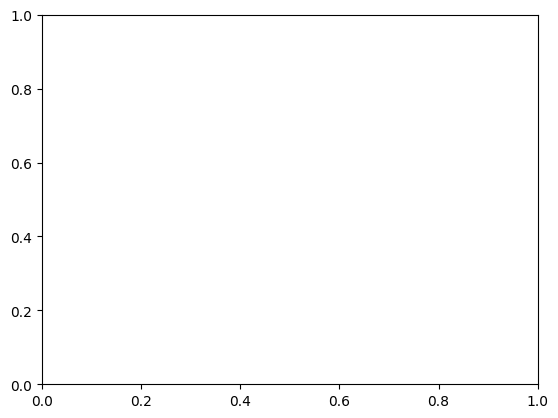

In [14]:
plt.plot(nxs, lumis)
plt.show()

In [16]:
print(lumis)

[np.float64(5.29999350855522e+22)]
